In [1]:
import os
import json
import pandas as pd
import torch
import cv2
import matplotlib.pyplot as plt

In [2]:
results_dir = "results"
os.chdir("..")

In [3]:
import os
import sys
import numpy as np
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from skimage.transform import resize
from skimage import measure
from PIL import Image
import os
import pandas as pd
import json
from ultralytics.models.yolo.detect import DetectionValidator
from ultralytics.models.yolo.obb import OBBValidator
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes
t = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
results_dir = "/mnt/faster0/adjt20/YOLOcore_git_code/results"

def calculate_area(box):
    # Box is [x_min, y_min, x_max, y_max]
    width = max(0, box[2] - box[0])
    height = max(0, box[3] - box[1])
    return width * height

def calculate_intersection(box1, box2):
    x_min = max(box1[0], box2[0])
    y_min = max(box1[1], box2[1])
    x_max = min(box1[2], box2[2])
    y_max = min(box1[3], box2[3])
    
    # Calculate intersection area
    width = max(0, x_max - x_min)
    height = max(0, y_max - y_min)
    
    return width * height

def intersection_over_area_of_smallest_box(box1, box2):
    # Calculate the intersection area
    intersection_area = calculate_intersection(box1, box2)
    
    # Calculate the area of both boxes
    area1 = calculate_area(box1)
    area2 = calculate_area(box2)
    
    # Find the smallest area
    smallest_area = min(area1, area2)
    
    # If there is no intersection, return 0
    if intersection_area == 0 or smallest_area == 0:
        return 0
    
    # IoA: Intersection over the area of the smallest box
    return intersection_area / smallest_area

def filter_bounding_boxes_recursive(bboxes, threshold):
    """
    Recursively filters bounding boxes by removing any boxes with an IoA 
    less than a given threshold.

    :param bboxes: List of bounding boxes in the format [(x1, y1, x2, y2), ...]
    :param threshold: The IoA threshold to decide if a box should be removed
    :return: A filtered list of bounding boxes
    """
    
    # Base case: if the list is empty or has only one bounding box, return it as is
    if len(bboxes) <= 1:
        return bboxes
    
    # Take the first bounding box from the list
    first_box = bboxes[0]
    filtered_boxes = [first_box]  # Start with the first box in the filtered list

    # Iterate over the rest of the bounding boxes
    remaining_boxes = bboxes[1:]

    # Recursively check each of the remaining boxes
    def should_keep_box(box):
        # Check IoA between the current box and all previously filtered boxes
        for filtered_box in filtered_boxes:
            if intersection_over_area_of_smallest_box(filtered_box, box) >= threshold:
                return False
        return True

    # Keep only the boxes that meet the IoA threshold
    remaining_filtered_boxes = [box for box in remaining_boxes if should_keep_box(box)]

    # Recursively process the remaining boxes
    return filtered_boxes + filter_bounding_boxes_recursive(remaining_filtered_boxes, threshold)

def filter_bounding_boxes_ioa(boxes, threshold=0.9):
    if len(boxes) == 0:
        return torch.empty(0, 5)
    bounding_boxes_out = filter_bounding_boxes_recursive(boxes, threshold=threshold)
    bounding_boxes_out = [np.array(item) for item in bounding_boxes_out]
    if isinstance(bounding_boxes_out, list):
        return torch.tensor(np.stack(bounding_boxes_out))
    return torch.tensor(bounding_boxes_out)  
    
def get_labels(label_path):
    if os.path.getsize(label_path)==0:
        return torch.empty(0, 4)
    return torch.tensor([[float(i) for i in item.split(" ")] for item in pd.read_csv(label_path, header=None, index_col=False).values[:,0]])[:,1:]

def load_im2im_paths(cfg):
    if cfg[-5:]==".yaml":
        cfg = cfg[:-5]
    path = os.path.join(os.getcwd(), 
                "ultralytics", 
                "cfg", 
                "datasets", 
                cfg+"_im2im_paths.json")
    with open(path, "r") as f:
        return json.load(f)
    
from torchvision.ops import box_convert

def calculate_area(box):
    # Box is [x_min, y_min, x_max, y_max]
    width = max(0, box[2] - box[0])
    height = max(0, box[3] - box[1])
    return width * height

def calculate_intersection(box1, box2):
    x_min = max(box1[0], box2[0])
    y_min = max(box1[1], box2[1])
    x_max = min(box1[2], box2[2])
    y_max = min(box1[3], box2[3])
    
    # Calculate intersection area
    width = max(0, x_max - x_min)
    height = max(0, y_max - y_min)
    
    return width * height

def intersection_over_area_of_smallest_box(box1, box2):
    # Calculate the intersection area
    intersection_area = calculate_intersection(box1, box2)
    
    # Calculate the area of both boxes
    area1 = calculate_area(box1)
    area2 = calculate_area(box2)
    
    # Find the smallest area
    smallest_area = min(area1, area2)
    
    # If there is no intersection, return 0
    if intersection_area == 0 or smallest_area == 0:
        return 0
    
    # IoA: Intersection over the area of the smallest box
    return intersection_area / smallest_area

def filter_bounding_boxes_recursive(bboxes, threshold):
    """
    Recursively filters bounding boxes by removing any boxes with an IoA 
    less than a given threshold.

    :param bboxes: List of bounding boxes in the format [(x1, y1, x2, y2), ...]
    :param threshold: The IoA threshold to decide if a box should be removed
    :return: A filtered list of bounding boxes
    """
    
    # Base case: if the list is empty or has only one bounding box, return it as is
    if len(bboxes) <= 1:
        return bboxes
    
    # Take the first bounding box from the list
    first_box = bboxes[0]
    filtered_boxes = [first_box]  # Start with the first box in the filtered list

    # Iterate over the rest of the bounding boxes
    remaining_boxes = bboxes[1:]

    # Recursively check each of the remaining boxes
    def should_keep_box(box):
        # Check IoA between the current box and all previously filtered boxes
        for filtered_box in filtered_boxes:
            if intersection_over_area_of_smallest_box(filtered_box, box) >= threshold:
                return False
        return True

    # Keep only the boxes that meet the IoA threshold
    remaining_filtered_boxes = [box for box in remaining_boxes if should_keep_box(box)]

    # Recursively process the remaining boxes
    return filtered_boxes + filter_bounding_boxes_recursive(remaining_filtered_boxes, threshold)

def filter_bounding_boxes_ioa(boxes, threshold=0.9):
    if len(boxes) == 0:
        return torch.empty(0, 5)
    bounding_boxes_out = filter_bounding_boxes_recursive(boxes, threshold=threshold)
    bounding_boxes_out = [np.array(item) for item in bounding_boxes_out]
    if isinstance(bounding_boxes_out, list):
        return torch.tensor(np.stack(bounding_boxes_out))
    return torch.tensor(bounding_boxes_out)  
    
def get_labels(label_path):
    if os.path.getsize(label_path)==0:
        return torch.empty(0, 4)
    return torch.tensor([[float(i) for i in item.split(" ")] for item in pd.read_csv(label_path, header=None, index_col=False).values[:,0]])[:,1:]

def load_im2im_paths(cfg):
    if cfg[-5:]==".yaml":
        cfg = cfg[:-5]
    path = os.path.join(os.getcwd(), 
                "ultralytics", 
                "cfg", 
                "datasets", 
                cfg+"_im2im_paths.json")
    with open(path, "r") as f:
        return json.load(f)
    
def make_3d(image_2d):
    return torch.stack([image_2d]*3)

def xyxyxyxy2xywhr(x):
    """
    Convert batched Oriented Bounding Boxes (OBB) from [xy1, xy2, xy3, xy4] to [xywh, rotation]. Rotation values are
    returned in radians from 0 to pi/2.

    Args:
        x (numpy.ndarray | torch.Tensor): Input box corners [xy1, xy2, xy3, xy4] of shape (n, 8).

    Returns:
        (numpy.ndarray | torch.Tensor): Converted data in [cx, cy, w, h, rotation] format of shape (n, 5).
    """
    is_torch = isinstance(x, torch.Tensor)
    points = x.cpu().numpy() if is_torch else x
    points = points.reshape(len(x), -1, 2)
    rboxes = []
    for pts in points:
        # NOTE: Use cv2.minAreaRect to get accurate xywhr,
        # especially some objects are cut off by augmentations in dataloader.
        (cx, cy), (w, h), angle = cv2.minAreaRect(pts)
        rboxes.append([cx, cy, w, h, angle / 180 * np.pi])
    return torch.tensor(rboxes, device=x.device, dtype=x.dtype) if is_torch else np.asarray(rboxes)


def xywhr2xyxyxyxy(x):
    """
    Convert batched Oriented Bounding Boxes (OBB) from [xywh, rotation] to [xy1, xy2, xy3, xy4]. Rotation values should
    be in radians from 0 to pi/2.

    Args:
        x (numpy.ndarray | torch.Tensor): Boxes in [cx, cy, w, h, rotation] format of shape (n, 5) or (b, n, 5).

    Returns:
        (numpy.ndarray | torch.Tensor): Converted corner points of shape (n, 4, 2) or (b, n, 4, 2).
    """
    cos, sin, cat, stack = (
        (torch.cos, torch.sin, torch.cat, torch.stack)
        if isinstance(x, torch.Tensor)
        else (np.cos, np.sin, np.concatenate, np.stack)
    )

    ctr = x[..., :2]
    w, h, angle = (x[..., i : i + 1] for i in range(2, 5))
    cos_value, sin_value = cos(angle), sin(angle)
    vec1 = [w / 2 * cos_value, w / 2 * sin_value]
    vec2 = [-h / 2 * sin_value, h / 2 * cos_value]
    vec1 = cat(vec1, -1)
    vec2 = cat(vec2, -1)
    pt1 = ctr + vec1 + vec2
    pt2 = ctr + vec1 - vec2
    pt3 = ctr - vec1 - vec2
    pt4 = ctr - vec1 + vec2
    return stack([pt1, pt2, pt3, pt4], -2)

def draw_rotated_bounding_boxes(drawn_image, 
                                bbs, 
                                colors,
                                width  = 2):
    boxes_opencv = [np.intp(cv2.boxPoints(((rbb[0], rbb[1]), (rbb[2], rbb[3]), rbb[4]))) for rbb in bbs]
    out = drawn_image.permute(1, 2, 0).contiguous().numpy().astype(np.uint8)
    for box in boxes_opencv:
        out = cv2.drawContours(out, [box], 0, colors, 3)
    return np.transpose(out, (2, 0, 1))

In [4]:
def get_stats(dataset_key, run_key, result_key):
    name_key = dataset_key+"_"+run_key
    if run_key[-4:]=="_rot":
        name = "ultralytics_stats.json"
    else:
        name = "custom_stats.json"
    with open(os.path.join(results_dir, name_key, result_key, name), "r") as f:
        stats = json.load(f)
    return stats

def load_df(dataset_key, run_key, results_key):
    name_key = dataset_key+"_"+run_key
    return pd.read_csv(os.path.join(results_dir, name_key, results_key, "results_df.csv"))


    

In [5]:
%matplotlib inline

def retrieve_image(dataset_key, unique_key, results_key, image_ind, conf_thres, pred_limit=10, image_inds=None):
    pred_width = 4
    label_width = 4
    
    im2im_paths = load_im2im_paths(dataset_key+"_"+run_key)
    df = load_df(dataset_key=dataset_key, run_key=unique_key, results_key=results_key)

    if run_key[-4:]=="_rot":
        rotation = True
    else:
        rotation = False
        
    t = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

    for ii, (boxes, confs, path) in enumerate(df[["boxes", "confs", "paths"]].values[image_ind:image_ind+1, :]):
        
        boxes = json.loads(boxes)
        confs = json.loads(confs)

        if len(confs)==0:
            pass
            
        boxes_with_confs = torch.hstack((torch.tensor(boxes), 
                                         torch.tensor(confs)[:,None])) 

        if not rotation:
            filtered_boxes = filter_bounding_boxes_ioa(boxes_with_confs, 
                                                       threshold=0.8)
        else:
            filtered_boxes = boxes_with_confs
            
        print(confs)
        filtered_boxes = filtered_boxes[filtered_boxes[...,-1]>conf_thres,...][:pred_limit]
        image = t(Image.open(path))
        
        if image_inds:
            filtered_boxes = filtered_boxes[image_inds]
        
        drawn_image = (make_3d(image[0])*255).to(torch.uint8)
        if len(filtered_boxes)>0:
            if not rotation:
                drawn_image = draw_bounding_boxes(drawn_image, 
                                                  filtered_boxes[:,:4],
                                                  colors ="red",
                                                  width  = pred_width)
            else:
                filtered_boxes_np = filtered_boxes.numpy()
                filtered_boxes_np[:,4] = np.degrees(filtered_boxes_np[:,4])
                filtered_boxes_np = filtered_boxes_np.astype(np.uint8)
                drawn_image = torch.tensor(draw_rotated_bounding_boxes(drawn_image, 
                                                                        filtered_boxes_np, 
                                                                        colors = (255, 0, 0),
                                                                        width  = pred_width))
                                
        original, intermediate, label_path = im2im_paths[os.path.split(path)[1]]
        print(original)
        if "mvtec" in dataset_key:
            if "anomaly_test_grouped" in original:
                mask_path = original.replace("anomaly_test_grouped", "ground_truth_grouped").replace(".png", "_mask.png")
                mask_image = make_3d((t(Image.open(mask_path))*255)[0]).permute(1, 2, 0).to(torch.uint8)
            else:
                mask_image = torch.tensor(np.zeros((3, 256, 256), dtype=np.uint8)).permute(1, 2, 0)  
        else:   
            if "test" in original:
                mask_path = original.replace("test", "ground_truth").replace(".JPG", ".png")
                mask_image = make_3d((t(Image.open(mask_path))*255)[0]).permute(1, 2, 0).to(torch.uint8)
            else:
                mask_image = torch.tensor(np.zeros((3, 256, 256), dtype=np.uint8)).permute(1, 2, 0)  
        

        # plotting stuff
        label_box = get_labels(label_path)
        
        if len(label_box)>0:
            if not rotation:
                label_box_xyxy = 256*box_convert(label_box, 
                                                    in_fmt="cxcywh", 
                                                    out_fmt="xyxy")
                drawn_image = draw_bounding_boxes(drawn_image, 
                                                    label_box_xyxy,
                                                    colors = "blue",
                                                    width  = label_width)
                label_box_pred = label_box_xyxy
            else:
                lab_out = xyxyxyxy2xywhr(256*label_box)
                lab_out[:,-1] = np.degrees(lab_out[:,-1])
                
                if isinstance(drawn_image, np.ndarray):
                    drawn_image = torch.tensor(drawn_image)
                drawn_image = torch.tensor(draw_rotated_bounding_boxes(drawn_image, 
                                            lab_out.numpy().astype(np.uint8), 
                                            colors = (0, 0, 255),
                                            width  = label_width))
                label_box_pred = boxes_with_confs
                
                label_box = xyxyxyxy2xywhr(label_box)
                
        final_image = transforms.ToPILImage()(drawn_image)
        
        original_tensor = t(Image.open(original))
        
        original = transforms.ToPILImage()(original_tensor)
        
#         fig, axes = plt.subplots(1, 2)
#         axes[0].imshow(original)
#         axes[1].imshow(final_image)
        
        a, b, c = (original_tensor*255).to(torch.uint8), mask_image.permute(2, 0, 1), drawn_image
        return a, b, c

In [6]:
import torchvision

In [7]:
dataset_key = "mvtec_bottle"
run_key     = "initial_run_rot"
results_key = "initial_results"


In [13]:
def plot_images(dataset_key, unique_key, results_key, limit=5):
    for i in range(limit):
        ind_grid_args = {"pad_value" : 255}
        a, b, c = retrieve_image(dataset_key, unique_key, results_key, i, conf_thres=0.1)
        im = torchvision.utils.make_grid([a, b, c], rows=1, **ind_grid_args)
        mvtec_n1 = im
        plt.figure()
        plt.imshow(im.permute(1, 2, 0))

In [14]:
dataset_key = "mvtec_bottle"
unique_key     = "initial_run_rot"
results_key = "initial_results"

[0.3555753529071808, 0.3537769615650177, 0.27063003182411194]
/mnt/faster0/adjt20/benchmark_datasets/mvtec_anomaly_detection/bottle/anomaly_test_grouped/broken_large_000.png
[0.481792688369751, 0.29042840003967285]
/mnt/faster0/adjt20/benchmark_datasets/mvtec_anomaly_detection/bottle/anomaly_test_grouped/broken_large_001.png
[0.5365478992462158, 0.5116500854492188, 0.36030077934265137, 0.3466428816318512, 0.34573397040367126, 0.33996906876564026, 0.3285302519798279, 0.28342464566230774, 0.2706179916858673]
/mnt/faster0/adjt20/benchmark_datasets/mvtec_anomaly_detection/bottle/anomaly_test_grouped/broken_large_010.png
[0.3744041919708252]
/mnt/faster0/adjt20/benchmark_datasets/mvtec_anomaly_detection/bottle/anomaly_test_grouped/broken_large_011.png
[0.25532734394073486]
/mnt/faster0/adjt20/benchmark_datasets/mvtec_anomaly_detection/bottle/anomaly_test_grouped/broken_large_012.png


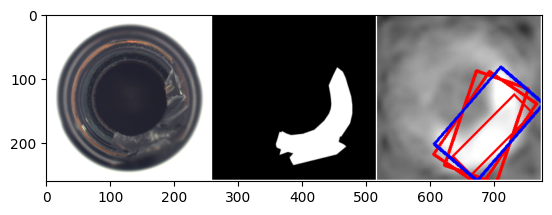

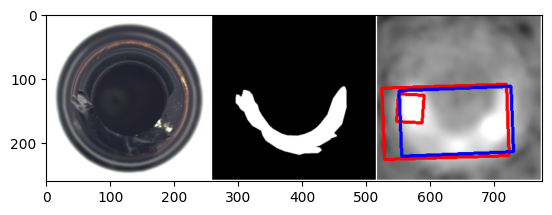

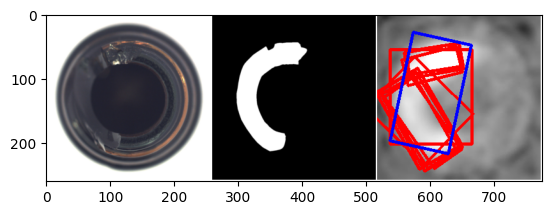

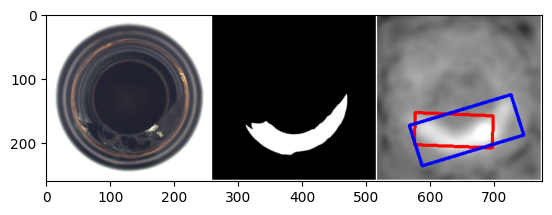

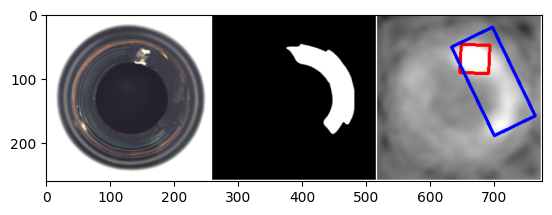

In [15]:
plot_images(dataset_key, unique_key, results_key, limit=5)

In [16]:
plot_images(dataset_key, run_key+"_rot", limit=5)

TypeError: plot_images() missing 1 required positional argument: 'results_key'